<a href="https://colab.research.google.com/github/123Satyajeet123/siamese_network_face_detection/blob/main/Face_detection_siamese_network_using_pretrained_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Necessary Modules

In [1]:
#some of blocks below are not used.

# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

from pathlib import Path
import sys

from glob import glob
from PIL import Image

In [2]:
# Importing torch and torchvision to get resnet model
import torch
import torchvision.models as models

# Loading the pre-trained ResNet-50 model with ImageNet weights
resnet = models.resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 78.2MB/s]


In [4]:
# creating a custom dataset class for the triplets dataset
import torch
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class TripletDataset(Dataset):
    def __init__(self, directory, triplet_list, transform=None):
        self.directory = directory
        self.triplet_list = triplet_list
        self.transform = transform

    def __len__(self):
        return len(self.triplet_list)

    def __getitem__(self, index):
        anchor, positive, negative = self.triplet_list[index]

        anchor_path = os.path.join(self.directory, anchor[0], anchor[1])
        positive_path = os.path.join(self.directory, positive[0], positive[1])
        negative_path = os.path.join(self.directory, negative[0], negative[1])

        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img



## Extracting Images from **IFW** Dataset

In [6]:


import zipfile

# Specify the path to the zip file
zip_file_path = '/content/drive/MyDrive/lfw_new.zip'  # Change to your actual file path

# Specify the directory where you want to extract the contents
extracted_path = '/extracted/'  # Change to your desired extraction path

# Create the target directory if it doesn't exist
import os
os.makedirs(extracted_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f'Zip file extracted to {extracted_path}')


Zip file extracted to /extracted/


In [7]:
ROOT = "/etracted/lfw_new"

In [16]:
ROOT = "/extracted/lfw_new"
import random
import os

def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list


train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)


Length of training list: 1512
Length of testing list : 168

Test List: {'James_Blake': 14, 'Luiz_Inacio_Lula_da_Silva': 48, 'Henrique_Meirelles': 2, 'Jorge_Castaneda': 2, 'Mike_Holmgren': 2, 'Lisa_Raymond': 2, 'Ricky_Ponting': 2, 'John_Jumper': 2, 'Martin_Hoellwarth': 2, 'Gloria_Macapagal_Arroyo': 44, 'Gao_Qiang': 2, 'Rachel_Griffiths': 3, 'Roberto_Benigni': 2, 'Fred_Thompson': 3, 'Jim_Carrey': 3, 'Tubby_Smith': 3, 'Guillaume_Soro': 2, 'Kim_Jong-Il': 4, 'Brian_Cowen': 2, 'Flavia_Delaroli': 2, 'Rita_Wilson': 4, 'Lisa_Gottsegen': 2, 'Kent_Rominger': 2, 'John_Blaney': 2, 'Gabriel_Valdes': 2, 'Joseph_Blatter': 2, 'Lauren_Killian': 2, 'Munir_Akram': 2, 'Akbar_Hashemi_Rafsanjani': 3, 'Sergey_Lavrov': 11, 'Lesley_McCulloch': 3, 'Bob_Dole': 3, 'Allison_Janney': 2, 'Jean-Marc_de_La_Sabliere': 2, 'Phil_Gramm': 2, 'Chang_Dae-whan': 2, 'Ben_Affleck': 7, 'Xavier_Malisse': 5, 'William_Ford_Jr': 7, 'Emmanuelle_Beart': 3, 'Hisao_Oguchi': 2, 'Arturo_Gatti': 3, 'Charles_Grassley': 2, 'Prince_Willem-Alex

In [17]:
print(train_list)

{'Ben_Howland': 4, 'Leonid_Kuchma': 6, 'Brooke_Shields': 2, 'Marco_Antonio_Barrera': 6, 'Walter_Mondale': 10, 'Francis_George': 2, 'Reese_Witherspoon': 4, 'Rick_Perry': 6, 'Anne_McLellan': 3, 'Paul_Sarbanes': 3, 'Bud_Selig': 4, 'Paul_Bremer': 20, 'Giuseppe_Gibilisco': 4, 'Shane_Warne': 2, 'Patrick_Leahy': 2, 'Sophia_Loren': 7, 'Butch_Davis': 2, 'Michael_J_Sheehan': 2, 'Carlos_Menem': 21, 'Eliane_Karp': 4, 'Emily_Robison': 2, 'Petro_Symonenko': 2, 'Corinne_Coman': 2, 'Antonio_Trillanes': 3, 'Geraldine_Chaplin': 4, 'Rebecca_Romijn-Stamos': 4, 'James_Cunningham': 3, 'Vaclav_Havel': 9, 'Rupert_Murdoch': 2, 'Tom_Craddick': 4, 'Kifah_Ajouri': 2, 'Scott_Wolf': 2, 'Diana_Munz': 3, 'Gian_Marco': 3, 'Rio_Ferdinand': 2, 'Richard_Norton-Taylor': 2, 'Leander_Paes': 2, 'Dwayne_Johnson': 2, 'Fred_Funk': 2, 'Hashim_Thaci': 2, 'Wolfgang_Schuessel': 4, 'Hillary_Clinton': 14, 'Jodie_Foster': 3, 'Spencer_Abraham': 17, 'Mark_Heller': 2, 'Jack_Straw': 28, 'Barbra_Streisand': 3, 'Carlos_Moya': 19, 'Julie_Ger

# Creating Triplets building dataloader and converting to torch tensors

In [18]:
import os

# Creating triplets (anchor,positive,negative)
def creating_triplets(directory, folder_list, max_files=20):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = os.listdir(path)
        num_files = len(files)

        if num_files < 2:
            continue

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets


In [19]:
train_triplet = creating_triplets(ROOT, train_list)
test_triplet  = creating_triplets(ROOT, test_list)

In [20]:
print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(20):
    print(train_triplet[i])


Number of training triplets: 230880
Number of testing triplets : 11377

Examples of triplets:
(('George_W_Bush', '448.jpg'), ('George_W_Bush', '471.jpg'), ('Robert_Kocharian', '2.jpg'))
(('George_W_Bush', '29.jpg'), ('George_W_Bush', '370.jpg'), ('Joan_Claybrook', '1.jpg'))
(('George_W_Bush', '252.jpg'), ('George_W_Bush', '343.jpg'), ('Anthony_Hopkins', '0.jpg'))
(('George_W_Bush', '326.jpg'), ('George_W_Bush', '386.jpg'), ('Tracy_McGrady', '1.jpg'))
(('Colin_Powell', '168.jpg'), ('Colin_Powell', '202.jpg'), ('Theresa_May', '1.jpg'))
(('George_W_Bush', '8.jpg'), ('George_W_Bush', '129.jpg'), ('Jamie_Villafane', '0.jpg'))
(('Colin_Powell', '81.jpg'), ('Colin_Powell', '221.jpg'), ('Carlos_Ortega', '1.jpg'))
(('George_W_Bush', '131.jpg'), ('George_W_Bush', '298.jpg'), ('Aleksander_Kwasniewski', '2.jpg'))
(('George_W_Bush', '422.jpg'), ('George_W_Bush', '495.jpg'), ('Joerg_Haider', '0.jpg'))
(('George_W_Bush', '147.jpg'), ('George_W_Bush', '376.jpg'), ('Kalpana_Chawla', '2.jpg'))
(('George

In [21]:
# creating a custom dataset class for the triplets dataset
import torch
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class TripletDataset(Dataset):
    def __init__(self, directory, triplet_list, transform=None):
        self.directory = directory
        self.triplet_list = triplet_list
        self.transform = transform

    def __len__(self):
        return len(self.triplet_list)

    def __getitem__(self, index):
        anchor, positive, negative = self.triplet_list[index]

        anchor_path = os.path.join(self.directory, anchor[0], anchor[1])
        positive_path = os.path.join(self.directory, positive[0], positive[1])
        negative_path = os.path.join(self.directory, negative[0], negative[1])

        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img



In [22]:
tripletDataset1 = TripletDataset(
    ROOT,
    train_triplet,
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
)
tripletDataset2 = TripletDataset(
    ROOT,
    test_triplet,
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
)

In [8]:
tripletDataset1 = torch.load('tripletDataset1.pt')
tripletDataset2 = torch.load('tripletDataset2.pt')

In [23]:
trainLoader = torch.utils.data.DataLoader(
    tripletDataset1, batch_size=64, shuffle=True, num_workers=2
)
testLoader = torch.utils.data.DataLoader(
    tripletDataset2, batch_size=64, shuffle=True, num_workers=2
)


# Building the Siamese Network using Pretrained Resnet and custom layers

In [36]:

class SiameseNetwork(nn.Module):
    def __init__(self, num_hidden_units_fc1=256, num_hidden_units_fc2=128):
        super(SiameseNetwork, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False  # Make the ResNet layers non-trainable

        self.resnet.fc = nn.Linear(2048, num_hidden_units_fc1)
        self.fc1 = nn.Linear(num_hidden_units_fc1, num_hidden_units_fc2)
        self.fc2 = nn.Linear(num_hidden_units_fc2, 2)

    def forward(self, x):
        x = self.resnet(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

siamese = SiameseNetwork()
print(siamese)


SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

## Custom loss function for **triplet loss** as we are using triplets instead or regular (Anchor and Positive)

In [37]:


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

triplet_loss = TripletLoss()

#Function for Training the Siamese Network and using the custom loss function to minimize

In [38]:
import torch.optim as optim

optimizer = optim.Adam(siamese.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Move your Siamese network and optimizer to the same device
siamese.to(device)
# create a function to train the model
#optimizer = optimizer.to(device)

def train_siamese(model, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    losses = []
    total_loss = 0
    for batch_idx, (anchor, positive, negative) in enumerate(train_loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # Forward pass
        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)


        # Calculate the triplet loss
        loss = triplet_loss(anchor_output, positive_output, negative_output)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(anchor),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            losses.append(total_loss / log_interval)
            total_loss = 0
    return losses



Device: cuda
Train Epoch: 1 [0/230880 (0%)]	Loss: 0.056469
Train Epoch: 1 [6400/230880 (3%)]	Loss: 0.085551
Train Epoch: 1 [12800/230880 (6%)]	Loss: 0.093557
Train Epoch: 1 [19200/230880 (8%)]	Loss: 0.062992
Train Epoch: 1 [25600/230880 (11%)]	Loss: 0.086378
Train Epoch: 1 [32000/230880 (14%)]	Loss: 0.137659
Train Epoch: 1 [38400/230880 (17%)]	Loss: 0.064453
Train Epoch: 1 [44800/230880 (19%)]	Loss: 0.040658
Train Epoch: 1 [51200/230880 (22%)]	Loss: 0.034887
Train Epoch: 1 [57600/230880 (25%)]	Loss: 0.086143
Train Epoch: 1 [64000/230880 (28%)]	Loss: 0.045453
Train Epoch: 1 [70400/230880 (30%)]	Loss: 0.039678
Train Epoch: 1 [76800/230880 (33%)]	Loss: 0.098527
Train Epoch: 1 [83200/230880 (36%)]	Loss: 0.049552
Train Epoch: 1 [89600/230880 (39%)]	Loss: 0.007653
Train Epoch: 1 [96000/230880 (42%)]	Loss: 0.003645
Train Epoch: 1 [102400/230880 (44%)]	Loss: 0.024793
Train Epoch: 1 [108800/230880 (47%)]	Loss: 0.059347
Train Epoch: 1 [115200/230880 (50%)]	Loss: 0.174308
Train Epoch: 1 [121600/2

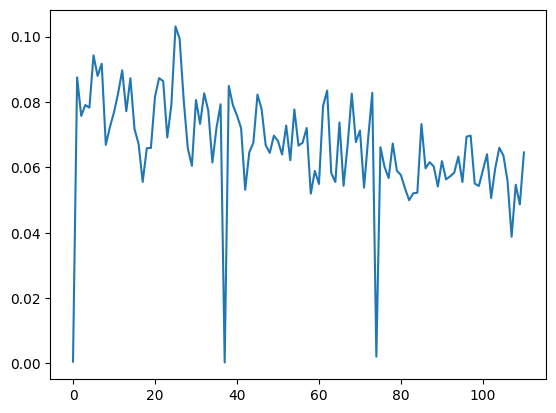

In [44]:
# training the model
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_epochs = 3
log_interval = 100

train_losses = []
for epoch in range(1, num_epochs + 1):
    train_loss = train_siamese(siamese, trainLoader, optimizer, epoch, log_interval)
    train_losses.extend(train_loss)

# plot the training loss
plt.plot(train_losses)

In [45]:

 Replace 'your_model' with the actual variable containing your trained model
torch.save(siamese.state_dict(), '/content/drive/My Drive/siamese_resnet_model.pth')


SyntaxError: ignored

In [46]:
# check how many images are correctly classified by the model on the test set and how many are incorrectly classified

def test_siamese(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)
            test_loss += triplet_loss(anchor_output, positive_output, negative_output).item()

            #checks if the anchor is closer to the positive image than to the negative image
            correct += ((anchor_output < positive_output) & (anchor_output < negative_output)).type(torch.float).sum().item()
    test_loss /= len(test_loader.dataset)
    print("Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)))


In [47]:
test_siamese(siamese, testLoader)

Average loss: 0.0189, Accuracy: 6962.0/11377 (61%)

